## Machine Learning : Treineiros ENEM 2016

O Exame Nacional do Ensino Média é uma prova realizada pelo Instituto Nacional de Estudos e Pesquisas Educacionais Anísio Teixeira, vinculada ao Ministério da Educação. Ele é utilizada para avaliar a qualidade de ensino no país, como também para acesso ao ensino superior em universidades públicas brasileirias através do Sistema de Selação Unificada.

## 1 - Coleta de dados

Para a construção do modelo preditivo, os dados que foram analisados estão separados em dois arquivos com extensão *.csv*, que são dados para treinamento **(train.csv)** e para teste **(test.csv)**. O arquivo de treinamento contém 13730 linhas e 167 colunas, sendo **NU_NOTA_MT** a variável que deverá ser prevista; e o arquivo de teste contém 4576 linhas e 47 colunas.

Para coletar esses dados, ambos os arquivos foram transferidos para uma estrutura de DataFrame, da biblioteca *pandas*.

In [2]:
# Não mostrar avisos
import warnings
warnings.filterwarnings('ignore')

# Instalar a biblioteca scikit-plot
!pip install -q scikit-plot

In [3]:
# Importação dos pacotes que serão utilizados

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix

from imblearn.over_sampling import SMOTE

pd.options.display.max_columns = None

# Configuração das cores dos gráficos
sns.set_palette(sns.diverging_palette(145, 280, s=85, l=25, n=7))
alpha = 0.8

# Criação das variáveis para fazer processamento de variáveis dummies e 
# padronização dos dados
labelencoder =  LabelEncoder()
scaler = StandardScaler()

In [35]:
# Leitura dos datasets de treinamento e teste do modelo
df_treino = pd.read_csv('train.csv')
df_teste = pd.read_csv('test.csv')

# Salva os ID's dos passageiros para submissão final
ids = df_teste.NU_INSCRICAO

## 2 - Tratativa dos Dados

Como o conjunto de dados de treino conta com 167 colunas, foi importante primeiro verificar quais delas continham informações úteis e quais podiam ser excluidas para não deixar o conjunto de dados muito grande. Percebeu-se uma divergência entre a quantidade de colunas no conjunto de teste e treino, logo foi realizao um filtro com somente as colunas que são encontradas nas duas bases de dados.

Após essa exclusão das colunas, os dois conjuntos foram concatenados para facilitar nas tratativas. A coluna de nota de matemática para o conjunto de teste assumiu o valor -1 para diferencia-la.

In [36]:
# Verificando as colunas que estão presentes nos dois datasets
colunas = list(filter(lambda x: x in df_treino.columns,df_teste.columns))
colunas.append('IN_TREINEIRO')

# Exclusão das colunas que não serão utilizadas
df_treino = df_treino.filter(items = colunas, axis = 1)
df_teste['IN_TREINEIRO'] = -1

# Concatena em um dataset o conjunto de treinamento e conjunto de teste para realizar tratativas
df = df_treino.append(df_teste, ignore_index = True)

# Limite para separação dos dataframes no futuro
limite_treino = len(df_treino)
limite_teste = len(df) - len(df_teste)

O primeiro passo foi verificar quais colunas possuem dados ausentes, para isso utilizou-se o método *isnull* e *any* para retornar quais colunas possuem dados ausentes. Todas as colunas foram analisadas com o intuito de verificar futuramente quais colunas possuem correlações fortes com nossa variável desejada.

Analisando do começo da lista, a primeira coluna que possuia dados ausentes foi a de **TP_ENSINO**, nela indicava em que tipo de instituição o candidato concluiu ou concluirá o ensino médio. Abaixo segue a lista que indica valor que pode ser representado:

**1:** Ensino Regular

**2:** Educação Especial - Modalidade Substitutiva

**3:** Educação de Jovens e Adultos

Quando quantificado o número de valores ausentes e quantos valores realmente estão preenchido, analiou-se que para essa coluna 2/3 dos dados possuem valores ausentes. Como conclusão essa coluna foi excluída por não agregar valor a análise.

In [37]:
df.TP_ENSINO.isnull().value_counts()

True     12592
False     5708
Name: TP_ENSINO, dtype: int64

In [38]:
df.drop(['TP_ENSINO'], axis =1, inplace = True)

A próxima coluna que possuia dados ausentes foi a **TP_DEPENDENCIA_ADM_ESC** que representa a dependência administrativa da escola com as seguintes categorias:

**1:** Federal

**2:** Estadual

**3:** Municipal

**4:** Privada

Verificou-se que já existia uma coluna que representa a informação com o tipo de escola, como também apresentava aproximadamente 2/3 de informações ausentes, essa coluna foi das análises.


In [39]:
df.TP_DEPENDENCIA_ADM_ESC.isnull().value_counts()

True     12592
False     5708
Name: TP_DEPENDENCIA_ADM_ESC, dtype: int64

In [40]:
df.drop(['TP_DEPENDENCIA_ADM_ESC'], axis =1, inplace = True)

Para as notas ausentes, verificou-se se o participante estava presente na prova, ou se realmente zerou a matéria, a partir das colunas **TP_PRESENCA_XX**. Como a coluna de presença para matemática não estava presente em ambos os datasets, sabe-se que a prova de matemática ocorre no mesmo dia que a prova de linguagens, assim, utilizou-se essa informação. As categorias das colunas de presença são:

**0:** Faltou a prova

**1:** Presente na prova

**2:** Eliminado na prova

Para os candidatos pertencentes ao grupo 0 e 2 foi inserido a nota 0, uma vez que não estavam presentes na prova ou foram eliminados do concurso. Já para a nota de redação como não existe uma informação sobre presença também foi inserido nota 0 para todas as competências que não possuem informação, como também considerar que o **TP_STATUS_REDACAO** pertence a categoria 4 (prova em branco).

In [41]:
df.isnull().sum()

NU_INSCRICAO            0
CO_UF_RESIDENCIA        0
SG_UF_RESIDENCIA        0
NU_IDADE                0
TP_SEXO                 0
TP_COR_RACA             0
TP_NACIONALIDADE        0
TP_ST_CONCLUSAO         0
TP_ANO_CONCLUIU         0
TP_ESCOLA               0
IN_BAIXA_VISAO          0
IN_CEGUEIRA             0
IN_SURDEZ               0
IN_DISLEXIA             0
IN_DISCALCULIA          0
IN_SABATISTA            0
IN_GESTANTE             0
IN_IDOSO                0
TP_PRESENCA_CN          0
TP_PRESENCA_CH          0
TP_PRESENCA_LC          0
TP_PRESENCA_MT          0
NU_NOTA_CN           4501
NU_NOTA_CH           4501
NU_NOTA_LC           4767
TP_LINGUA               0
TP_STATUS_REDACAO    4767
NU_NOTA_COMP1        4767
NU_NOTA_COMP2        4767
NU_NOTA_COMP3        4767
NU_NOTA_COMP4        4767
NU_NOTA_COMP5        4767
NU_NOTA_REDACAO      4767
Q001                    0
Q002                    0
Q006                    0
Q024                    0
Q025                    0
Q026        

In [42]:
# Para os candidatos ausentes ou que foram eliminados da prova preenche com a nota 0
df.NU_NOTA_CN.loc[df.TP_PRESENCA_CN == 0] = 0
df.NU_NOTA_CN.loc[df.TP_PRESENCA_CN == 2] = 0

df.NU_NOTA_CH.loc[df.TP_PRESENCA_CH == 0] = 0
df.NU_NOTA_CH.loc[df.TP_PRESENCA_CH == 2] = 0

df.NU_NOTA_LC.loc[df.TP_PRESENCA_LC == 0] = 0
df.NU_NOTA_LC.loc[df.TP_PRESENCA_LC == 2] = 0

df.NU_NOTA_COMP1.loc[pd.isnull(df.NU_NOTA_COMP1)] = 0
df.NU_NOTA_COMP2.loc[pd.isnull(df.NU_NOTA_COMP2)] = 0
df.NU_NOTA_COMP3.loc[pd.isnull(df.NU_NOTA_COMP3)] = 0
df.NU_NOTA_COMP4.loc[pd.isnull(df.NU_NOTA_COMP4)] = 0
df.NU_NOTA_COMP5.loc[pd.isnull(df.NU_NOTA_COMP5)] = 0
df.NU_NOTA_REDACAO.loc[pd.isnull(df.NU_NOTA_REDACAO)] = 0
df.TP_STATUS_REDACAO.loc[pd.isnull(df.TP_STATUS_REDACAO)] = 4

In [43]:
df.TP_ANO_CONCLUIU.value_counts()

0     9578
1     2119
10    1570
2     1394
3      959
4      723
5      511
6      489
7      397
8      287
9      273
Name: TP_ANO_CONCLUIU, dtype: int64

In [52]:
df['NAO CONCLUIU'] = df.TP_ANO_CONCLUIU.apply(lambda x: 1 if x == 0 else 0)
df['TREINO'] = df.TP_ST_CONCLUSAO.apply(lambda x: 1 if x == 3 or x == 4 else 0)
df['MENOR'] = df.apply(lambda x: 1 if x.TP_ST_CONCLUSAO >= 3 and x.NU_IDADE < 18 else 0, axis = 1)

Para a coluna **TP_STATUS_REDACAO** foi modificado as classes para somente duas, 0 quando a redação não apresenta problemas e 1 quando a redação apresenta problemas, com as possibilidades de: anulada, cópia do texto motivador, em branco, fere os direitos humanos, fuga ao tema, não atendimento ao tipo, texto insuficiente ou parte desconectada.

In [54]:
df.TP_STATUS_REDACAO.loc[df.TP_STATUS_REDACAO == 1] = 0
df.TP_STATUS_REDACAO.loc[df.TP_STATUS_REDACAO > 1] = 1

Na pergunta Q27 não existia uma resposta que incluia os candidados que não exercem atividade remunerada, e que estão somente estudando. Com isso foi criado uma categoria N para agrega-los.

In [55]:
df.Q027.loc[pd.isnull(df.Q027)] = 'N'

Como todo o dataset já está sem dados missing, ocorreu a transformação as variáveis categóricas para discretas para utilização do modelo matemático de regessão linear, porém, antes dessa transformação, algumas colunas serão excluídas, uma vez que não serão importantes para análise.

Após esses procedimentos o conjunto de dados de treino foi separado do conjunto de dados de teste. Outra etapa importante foi excluir a coluna **NU_NOTA_MT** do conjunto de dados de teste.

In [56]:
# Exclusão de colunas não relavantes
df.drop(['SG_UF_RESIDENCIA','NU_INSCRICAO'], axis = 1, inplace = True)

# Transformação de categórico para discreto
df.TP_SEXO = labelencoder.fit_transform(df.TP_SEXO)
df.Q001 = labelencoder.fit_transform(df.Q001)
df.Q002 = labelencoder.fit_transform(df.Q002)
df.Q006 = labelencoder.fit_transform(df.Q006)
df.Q024 = labelencoder.fit_transform(df.Q024)
df.Q025 = labelencoder.fit_transform(df.Q025)
df.Q026 = labelencoder.fit_transform(df.Q026)
df.Q027 = labelencoder.fit_transform(df.Q027)
df.Q047 = labelencoder.fit_transform(df.Q047)

In [57]:
# Separando o conjunto de treino e teste
treino = df[:limite_treino]
teste = df[limite_teste:]
teste.drop(['IN_TREINEIRO'], axis = 1, inplace = True)

## 3 - Análise Exploratória

Nessa etapa foi verificado todas as possíveis relações entre as variáveis que afetam diretamente no resultado da nota de matemática. Foi verificado quais colunas serão utilizadas no modelo e quais não serão utilizadas. Uma análise muito importante é a de correlação, verificando se são fortes, fracas ou não existe correlação.

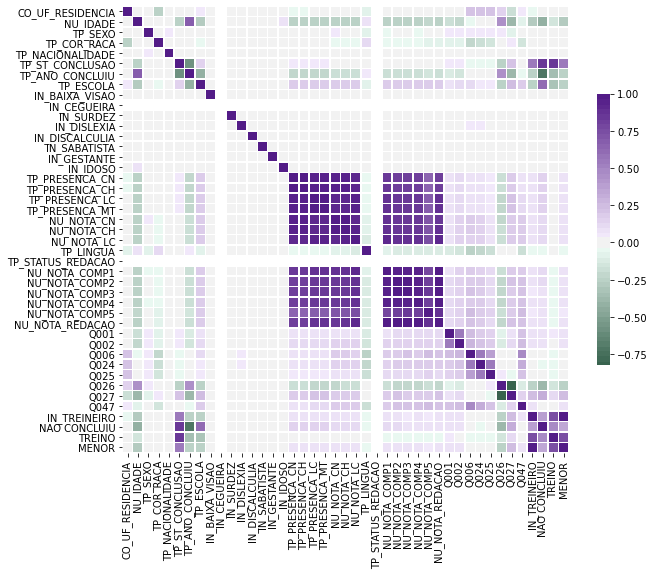

In [58]:
# Matriz de correlação
def corr(df):
  corr = df.corr()
  f, ax = plt.subplots(figsize= (10, 10))
  cmap = sns.diverging_palette(145, 280, s=85, l=25, n=60)
  sns.heatmap(corr, cmap = cmap, vmax = 1, center = 0, square = True, linewidths= .5, cbar_kws= {'shrink': .5})
  plt.show()

corr(treino)

Após plotar a matriz de correlação verificou-se várias variáveis que possuem correlação zero com a variável que deverá ser prevista. Todas essas colunas foram excluídas para não atrapalhar no modelo, uma vez que não são importantes.

In [59]:
# Exclusão das colunas que possuem correlação zero

teste.drop(['CO_UF_RESIDENCIA', 'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE','IN_BAIXA_VISAO', 'IN_CEGUEIRA','IN_SURDEZ','IN_DISLEXIA', 'IN_DISCALCULIA','IN_SABATISTA', 'IN_GESTANTE','IN_IDOSO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH',
'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3',
'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025','Q047', 'Q027', 'Q026'],
        axis = 1, inplace = True)

treino.drop(['CO_UF_RESIDENCIA', 'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE','IN_BAIXA_VISAO', 'IN_CEGUEIRA','IN_SURDEZ','IN_DISLEXIA', 'IN_DISCALCULIA','IN_SABATISTA', 'IN_GESTANTE','IN_IDOSO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH',
'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3',
'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025','Q047', 'Q027', 'Q026'],
        axis = 1, inplace = True)

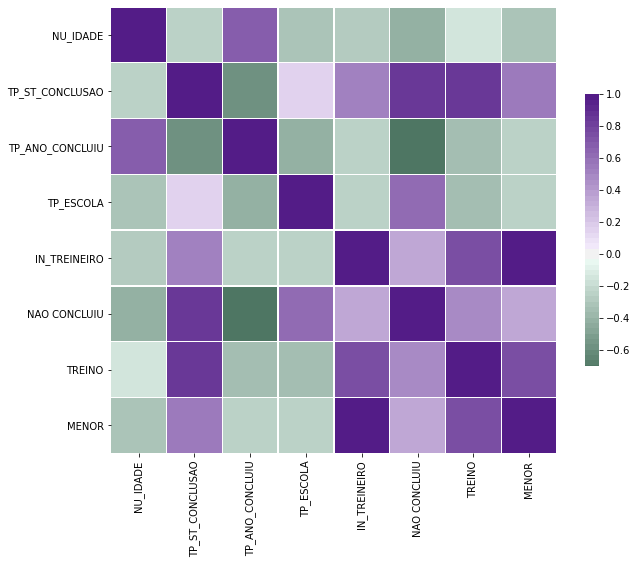

In [60]:
# Nova matriz de correlação, removendo as colunas com correlação fraca
corr(treino)

## 4 - Modelo preditivo

Para esse modelo preditivo será utilizado a Regressão Linear. Na área da estatística ela é utilizada para se estimar a condicional de uma variável y, dados os valores de algumas variáveis x. Nessa nosso caso estamos dando informações sobre o candidado e esperamos que o modelo nos retorne sua possível nota em matemática.

Antes de realizar esse processo vamos excluir a coluna **NU_NOTA_MT** das features do conjunto de dados de treino para gerar a variável X e adiciona-la na variável y. Após esse processo vamos dividir nosso conjunto de treino entre "treino" e "teste" para conseguirmos verificar qual a porcentagem de acerto que o modelo está nos retornando.

In [61]:
treino.IN_TREINEIRO.value_counts()

0    11947
1     1783
Name: IN_TREINEIRO, dtype: int64

In [62]:
sm = SMOTE(random_state = 2)

In [63]:
X = treino.drop('IN_TREINEIRO', axis = 1)
y = treino.IN_TREINEIRO

print(np.count_nonzero(y == 0))
print(np.count_nonzero(y == 1))

11947
1783


In [64]:
X, y = sm.fit_sample(X, y.ravel())

print(np.count_nonzero(y == 0))
print(np.count_nonzero(y == 1))

11947
11947


In [65]:
X = scaler.fit_transform(X)
teste = scaler.fit_transform(teste)

In [66]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.3)

Como dito anteriormente foi utilizado a Regressão Linear e não utilizamos nenhum parâmetro no modelo. Para treinamento do modelo foi utilizado o conjunto de treino e para testa-lo o conjunto de teste.
Após realizar esse processo verificamos que em ambas as etapas, tanto de teste, quanto em treino o modelo nos retornou 92% de acerto, uma resultado aceitável.

In [67]:
# Range de parâmetros para o modelo
parametros = dict(
    criterion = ['gini', 'entropy'],
    max_depth = [n for n in range(3,6)],
    min_samples_split = [n for n in range(3,6)],
    min_samples_leaf = [n for n in range(3,6)],
    n_estimators = 100
)

In [68]:
modelo = RandomForestClassifier(random_state= 0)
modeloCV = GridSearchCV(estimator = modelo, param_grid = parametros, cv = 5, n_jobs = -1)

In [69]:
modeloCV.fit(X_treino, y_treino)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [4, 5], 'min_samples_leaf': [4, 5],
                         'min_samples_split': [4, 5],
                         'n_estimators': [80, 90]})

In [70]:
print('Melhor resultado: {}'.format(modeloCV.best_score_))
print('Parâmetros: {}'.format(modeloCV.best_estimator_))

Melhor resultado: 0.991270553064275
Parâmetros: RandomForestClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=4,
                       n_estimators=90, random_state=0)


In [71]:
# testa o modelo preditivo gerado
y_teste = modeloCV.predict(X_teste)
pd.Series(y_teste).value_counts()

1    3720
0    3449
dtype: int64

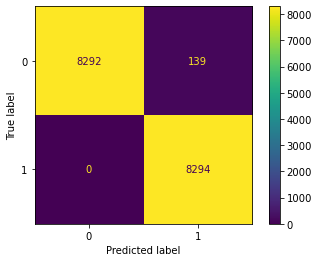

In [72]:
plot_confusion_matrix(modeloCV, X_treino, y_treino)

In [73]:
y_final = modeloCV.predict(teste)

In [74]:
dados_finais = pd.concat([pd.Series(ids, name = 'NU_INSCRICAO'),pd.Series(y_final, name = 'IN_TREINEIRO')], axis = 1)
dados_finais.to_csv('answer.csv', index = False)